# **Neural Network / Artificial Intelligence: Coursework 2 by Group 15**
This group consists of the following members:
1. Muskan Asmath - K2279003 
2. Abin Varghese - K2275285
3. Neha Gupta - K2263969
4. Amirali Monjar - K2205064


# **Timeseries Anomaly Detection**

# **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Conv1D, MaxPool1D
from keras.utils import plot_model 
from keras.models import Model
from keras.layers import Input, Reshape, LeakyReLU, ReLU
from keras.layers.core import Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import UpSampling1D, Conv1D
from keras.optimizers import Adam, SGD
#from keras.callbacks import TensorBoard
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler as mms                      # minmax scaler for normalizing between 0 and 1
from sklearn.model_selection import train_test_split as tts                # To split the dataset
from sklearn.decomposition import PCA                                      # PCA for dimensionality reduction
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import (accuracy_score, confusion_matrix,             # a few metrics for evaluation
                             silhouette_score, precision_score, f1_score, roc_auc_score,
                             classification_report,ConfusionMatrixDisplay, 
                             v_measure_score, adjusted_rand_score, 
                             calinski_harabasz_score, davies_bouldin_score, roc_curve, auc, RocCurveDisplay)
from imblearn.over_sampling import SMOTE  #SMOTE to handle imbalanced data
from imblearn.over_sampling._smote.base import Counter  #COUNTE

import warnings   
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import CondensedNearestNeighbour
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import InstanceHardnessThreshold
from sklearn.model_selection import train_test_split
from keras.layers import LSTM, Dense, Embedding, Dropout,Input
from keras import metrics
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from keras import regularizers
from keras.utils.vis_utils import plot_model
from PIL import Image
from keras.utils import to_categorical
from keras import models
from keras import layers
from tensorflow.keras.metrics import Recall
from google.colab import drive
                                                         # used to ignore the warnings
warnings.filterwarnings("ignore")

## Import Dataset 

In [ ]:
#Google Drive and Colab Mounting
from google.colab import drive
drive.mount('/content/gdrive')

df = pd.read_csv("/content/gdrive/MyDrive/MSc Data Science/datasets/creditcard.csv", encoding = "latin-1") #Abin
#df = pd.read_csv("/content//gdrive/MyDrive/creditcard.csv") #Muskan
#df = pd.read_csv("/content/gdrive/MyDrive/Datasets/creditcard.csv", encoding = "latin-1") #Neha

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Dataset Analysis**

In [ ]:
class TimeseriesAnomalyDetection:
  def __init__(self) -> None:
    return None

  def show_data(self, dataset):
    print(f"Printing the first 5 rows of the dataset:\n{tabulate(dataset.head(), headers='keys', tablefmt='psql')}\n\n")
    print(f"Printing the last 5 rows of the dataset:\n{tabulate(dataset.tail(), headers='keys', tablefmt='psql')}\n\n")
    print('*-----*-----*-----*-----*-----*-----*-----*-----*-----*-----*-----*-----*\n\n')

  def find_missing_values(self,dataset):
    tot_miss_val = dataset.isnull().sum().sum()
    print(f'Total number of missing values: {dataset.isnull().sum().sum()}')
    if tot_miss_val == 0:
      print('There are no missing values in this dataset.')
    else:
      print(tabulate(dataset[dataset.isnull()], headers='keys', tablefmt='psql'))

  def split_dataset(self, dataset):
    X =dataset.iloc[:, : -1]
    y = dataset.iloc[:, -1]
    X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.9, random_state = 42)
    return X_train, X_test, y_train, y_test
   
  def normalize_data(self, dataset): 
    print('Since we have a multivariant time-series anomaly detection problem')
    print('so the data needs to be normalised and formatted considering that they are multivariant.\n\n')
    X = dataset.iloc[:, : -1]
    y = dataset.iloc[:, -1]
    scaler = mms()
    scaler.fit(X)
    scaled_features = scaler.transform(X)
    return scaled_features

  def exploratory_data_analysis(self, dataset): #wip(Muskan)
    # normalize the dataset
    #scaled_features = self.normalize_data(dataset)
    # splitting the dataset
    X_train, X_test, y_train, y_test = self.split_dataset(dataset)
    # printing the splitted datset
    print('X_train shape ==>', X_train.shape)
    print('X_test shape ==>', X_test.shape)
    print('y_train shape ==>', y_train.shape)
    print('y_test shape ==>', y_test.shape)
    print('*--------*--------*--------*--------*--------*--------*--------*--------*--------*--------*\n\n')

    print('Finding the missing values:\n')
    self.find_missing_values(dataset)
    print('*--------*--------*--------*--------*--------*--------*--------*--------*--------*--------*\n\n')

    print('Printing the statistical summary of the dataset ==>\n\n')
    print(tabulate(dataset.describe(), headers='keys', tablefmt='psql'))
    print('*--------*--------*--------*--------*--------*--------*--------*--------*--------*--------*\n\n')

    print('Rendering a bar chart to visualize the number of fraudulent transactions ==>\n\n')
    #Number of times each class meets(fraud or not fraud) transaction
    count_frequency = pd.value_counts(dataset['Class'], sort=True)
    #bar chart to visualize transaction
    fig, ax = plt.subplots()
    bars = plt.bar(['Not Fraud', 'Fraud'], count_frequency)
    ax.bar_label(bars)
    
    plt.title("Fraud and Not Fraud Transaction Distribution")
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.show()
    print('*--------*--------*--------*--------*--------*--------*--------*--------*--------*--------*\n\n')

    print('Finding out the most important features - FEATURE IMPORTANCE RANKING ==>\n\n')

    # Train a random forest classifier
    rfc = RandomForestClassifier(random_state=42)
    rfc.fit(X_train, y_train)

    # Calculate feature importances using permutation importance
    perm_importance = permutation_importance(rfc, X_test, y_test)

    # Plot the feature importances using a bar chart
    fig, ax = plt.subplots(figsize = (15, 10))
    ax.barh(X_train.columns, perm_importance.importances_mean)
    ax.set_xlabel('Importance')
    ax.set_title('Feature Importances')
    plt.show()
    print('*--------*--------*--------*--------*--------*--------*--------*--------*--------*--------*\n\n')

    print("\n\n\t\t Check if any difference in the amount of money used in different transaction\n\n")
    Normal = df[df['Class']==0]
    Fraud = df[df['Class']==1]
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    f.suptitle('Amount per transaction by class')
    bins = 50
    ax1.hist(Fraud.Amount, bins = bins)
    ax1.set_title('Fraud')
    ax2.hist(Normal.Amount, bins = bins)
    ax2.set_title('Normal')
    plt.xlabel('Amount')
    plt.ylabel('Number of Transactions')
    plt.xlim((0, 20000))
    plt.yscale('log')
    plt.show()
    print('*--------*--------*--------*--------*--------*--------*--------*--------*--------*--------*\n\n')
    print("\n\n\t\t  Check when do most fraudulent transactions occur over time:\n\n")

    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    f.suptitle('Time of transaction vs Amount by class')
    ax1.scatter(Fraud['Time (second)'], Fraud['Amount'])
    ax1.set_title('Fraud')
    ax2.scatter(Normal['Time (second)'], Normal['Amount'])
    ax2.set_title('Normal')
    plt.xlabel('Time (Seconds)')
    plt.ylabel('Amount')
    plt.show()

    print("\nAs noted above, it doesn't appear like the timing of the transaction is really relevant in this case")

    #Correlation Matrix
    correlation_matrix = df.corr()
    fig = plt.figure(figsize=(12,9))
    sns.heatmap(correlation_matrix,vmax=0.8,square = True)
    plt.show()

    print("\nThe Correlation matrix demonstrates that none of the V1 through V28 PCA components are correlated with one another. However, class exhibits both positive and negative correlations with the V components, but not with time or amount.")

In [ ]:
tad = TimeseriesAnomalyDetection()                    # Making an object of the TimeSeriesAnamolyDetection Class
tad.show_data(df)

Printing the first 5 rows of the dataset:
+----+-----------------+-----------+------------+---------+-----------+------------+------------+-----------+------------+-----------+------------+-----------+------------+-----------+-----------+-----------+-----------+-----------+------------+-----------+------------+------------+------------+-----------+------------+-----------+-----------+------------+------------+----------+---------+
|    |   Time (second) |        V1 |         V2 |      V3 |        V4 |         V5 |         V6 |        V7 |         V8 |        V9 |        V10 |       V11 |        V12 |       V13 |       V14 |       V15 |       V16 |       V17 |        V18 |       V19 |        V20 |        V21 |        V22 |       V23 |        V24 |       V25 |       V26 |        V27 |        V28 |   Amount |   Class |
|----+-----------------+-----------+------------+---------+-----------+------------+------------+-----------+------------+-----------+------------+-----------+------------+

X_train shape ==> (28480, 30)
X_test shape ==> (256327, 30)
y_train shape ==> (28480,)
y_test shape ==> (256327,)
*--------*--------*--------*--------*--------*--------*--------*--------*--------*--------*


Finding the missing values:

Total number of missing values: 0
There are no missing values in this dataset.
*--------*--------*--------*--------*--------*--------*--------*--------*--------*--------*


Printing the statistical summary of the dataset ==>


+-------+-----------------+------------------+------------------+------------------+------------------+----------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+--

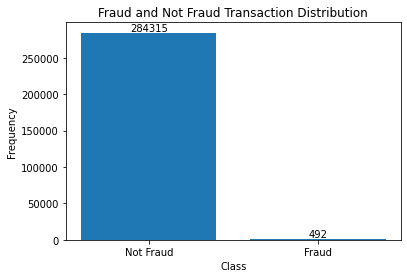

*--------*--------*--------*--------*--------*--------*--------*--------*--------*--------*


Finding out the most important features - FEATURE IMPORTANCE RANKING ==>




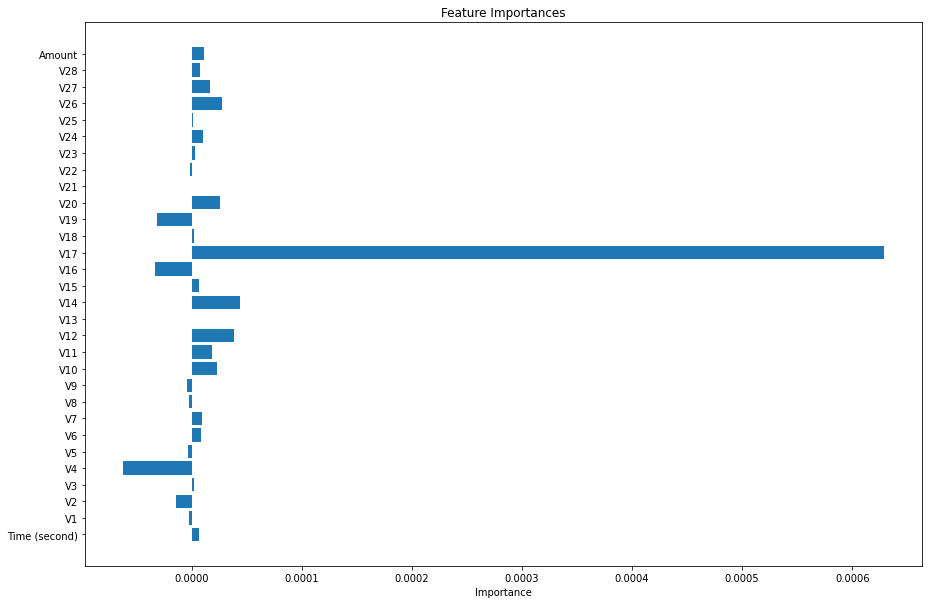

*--------*--------*--------*--------*--------*--------*--------*--------*--------*--------*




		 Check if any difference in the amount of money used in different transaction




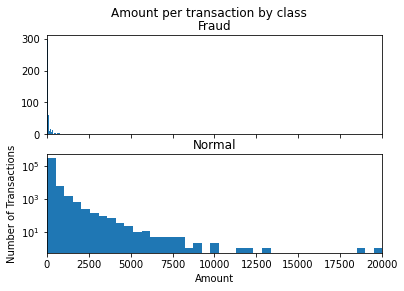

*--------*--------*--------*--------*--------*--------*--------*--------*--------*--------*




		  Check when do most fraudulent transactions occur over time:




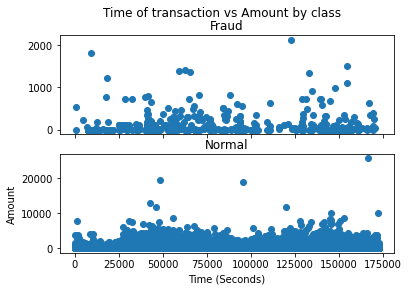


As noted above, it doesn't appear like the timing of the transaction is really relevant in this case


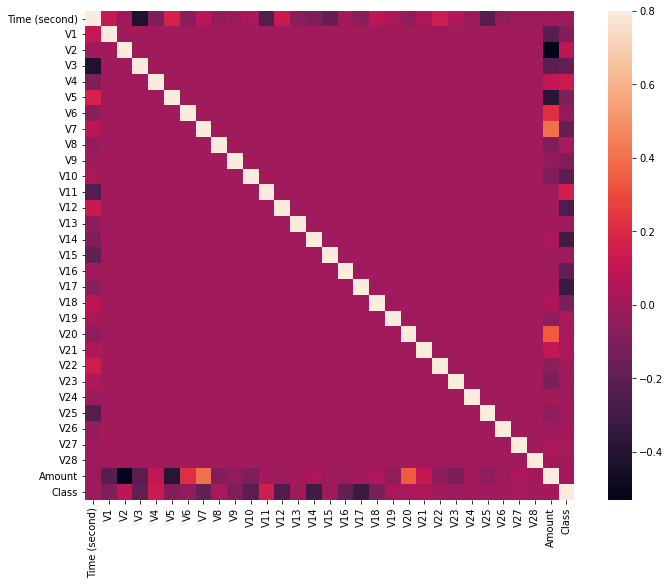


The Correlation matrix demonstrates that none of the V1 through V28 PCA components are correlated with one another. However, class exhibits both positive and negative correlations with the V components, but not with time or amount.


In [ ]:
tad.exploratory_data_analysis(df)

# Credit card fraud detection (Using CNN) 




In [ ]:
class DataPreProcessor:
  def __init__(self, dataset):
    self.dataset = dataset

  def Split_df(self,X,y):
    X_train,X_test,y_train,y_test=tts(X,y,test_size=0.2, random_state = 42)
    return X_train,X_test,y_train,y_test

  def resample(self,df):
    Normal = df[df['Class']==0]
    Fraud = df[df['Class']==1]

    Normal = Normal.sample(frac=2, replace=True)  #class-0 samples 

    Balanced_data = Fraud.append(Normal,ignore_index=True)
    Balanced_data.shape
    X = Balanced_data.drop(['Class'],axis=1)
    y = Balanced_data['Class']
    return X,y

  #CNN used for prediction so converting 2D dataset into 3D
  def Scaled_to_3D(self,X_train,X_test,y_train,y_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    y_train=y_train.to_numpy()
    y_test=y_test.to_numpy()

    #scaled x train in 3d
    X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
    X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)
    return X_train,X_test,y_train,y_test

In [ ]:
class CNN_Model:
  def __init__(self,X_train,X_test,y_train,y_test):
     self.X_train = X_train
     self.X_test = X_test
     self.y_train = y_train
     self.y_test = y_test

  def Model(self):
    cnn = keras.models.Sequential()

    #Adding the input layer and the first hidden layer
    cnn.add(Conv1D(32,2,activation='relu',input_shape=self.X_train[0].shape))
    cnn.add(BatchNormalization())# Batch normalization is a technique for training very deep neural networks 
                                  # that standardizes the inputs to a layer for each mini-batch. This 
                                  # has the effect of stabilizing the learning process and dramatically
                                  # reducing the number of training epochs required to train deep networks
    cnn.add(Dropout(0.2))        # prevents over-fitting (randomly remove some neurons)

    #Adding the second hidden layer
    cnn.add(Conv1D(64,2,activation='relu'))
    cnn.add(BatchNormalization())
    cnn.add(Dropout(0.5))

    cnn.add(Flatten())
    cnn.add(Dense(64,activation='relu'))
    cnn.add(Dropout(0.5))

    #the output layer
    cnn.add(keras.layers.Dense(units=1, activation='sigmoid'))
    cnn.summary()
    
    plot_model(cnn)
    return cnn

  def plotLearningCurve(self, history,epochs):
    epoch_range = range(1,epochs+1)
    plt.plot(epoch_range,history.history['accuracy'])
    plt.plot(epoch_range,history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train','Validation'],loc='center right')
    plt.show()

    plt.plot(epoch_range,history.history['loss'])
    plt.plot(epoch_range,history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train','Validation'],loc='center right')
    plt.show()

  def save_model(self, path = 'cnn_saved_model.h5'):
    cnn.save(path)
    print(f"Saved model at '{path}'.")

### Pre Processing Dataset

In [ ]:
cnn_premodel = DataPreProcessor(df)

In [ ]:
X,y=cnn_premodel.resample(df)
X_train,X_test,y_train,y_test = cnn_premodel.Split_df(X,y)

X_train,X_test,y_train,y_test = cnn_premodel.Scaled_to_3D(X_train,X_test,y_train,y_test)

In [ ]:
CnnModel = CNN_Model(X_train,X_test,y_train,y_test)

In [ ]:
cnn = CnnModel.Model()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 29, 32)            96        
                                                                 
 batch_normalization_8 (Batc  (None, 29, 32)           128       
 hNormalization)                                                 
                                                                 
 dropout_12 (Dropout)        (None, 29, 32)            0         
                                                                 
 conv1d_9 (Conv1D)           (None, 28, 64)            4160      
                                                                 
 batch_normalization_9 (Batc  (None, 28, 64)           256       
 hNormalization)                                                 
                                                                 
 dropout_13 (Dropout)        (None, 28, 64)           

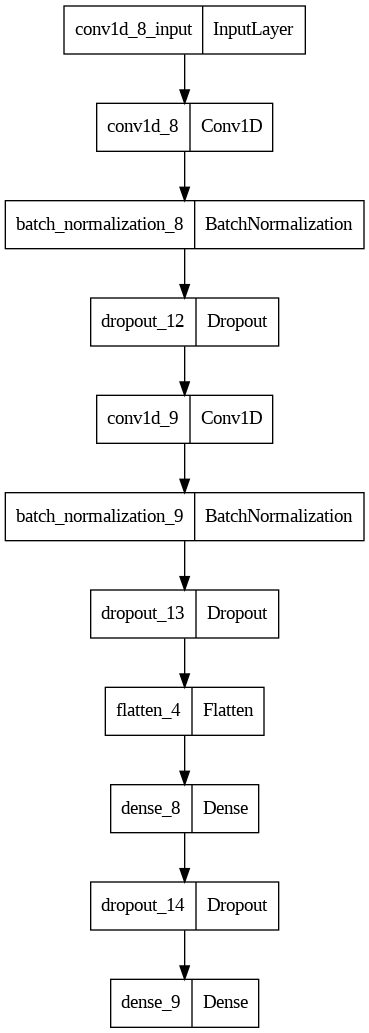

In [ ]:
plot_model(cnn)


 Training the CNN

### Compiling the CNN

In [ ]:
#cnn.compile(optimizer = Adam(learning_rate=0.0001), loss = "binary_crossentropy", metrics = ["accuracy"])
cnn.compile(optimizer = Adam(learning_rate=0.0001), loss = "binary_crossentropy", metrics = ["accuracy"])


### Training the CNN on the Training set

In [ ]:
history = cnn.fit(X_train,y_train, epochs = 20, validation_data=(X_test, y_test), verbose=1) 

Epoch 1/20
14229/14229 [==============================] - 173s 12ms/step - loss: 0.0158 - accuracy: 0.9955 - val_loss: 0.0037 - val_accuracy: 0.9995
Epoch 2/20
14229/14229 [==============================] - 145s 10ms/step - loss: 0.0034 - accuracy: 0.9995 - val_loss: 0.0028 - val_accuracy: 0.9995
Epoch 3/20
14229/14229 [==============================] - 141s 10ms/step - loss: 0.0032 - accuracy: 0.9995 - val_loss: 0.0026 - val_accuracy: 0.9995
Epoch 4/20
14229/14229 [==============================] - 152s 11ms/step - loss: 0.0031 - accuracy: 0.9995 - val_loss: 0.0025 - val_accuracy: 0.9995
Epoch 5/20
14229/14229 [==============================] - 148s 10ms/step - loss: 0.0028 - accuracy: 0.9995 - val_loss: 0.0023 - val_accuracy: 0.9995
Epoch 6/20
14229/14229 [==============================] - 155s 11ms/step - loss: 0.0025 - accuracy: 0.9996 - val_loss: 0.0022 - val_accuracy: 0.9995
Epoch 7/20
14229/14229 [==============================] - 144s 10ms/step - loss: 0.0024 - accuracy: 0.9996

## Part 4 - Making the predictions and evaluating the model

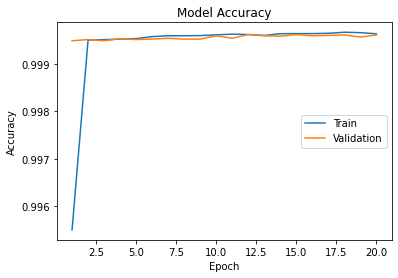

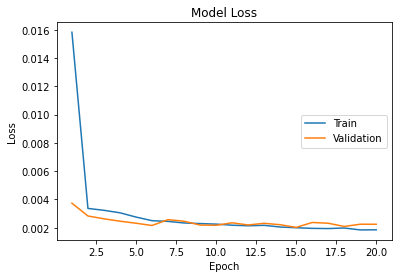

In [ ]:
CnnModel.plotLearningCurve(history,20) 

In [ ]:
from sklearn.metrics import confusion_matrix
cnn_predictions =  (cnn.predict(X_test) > 0.5).astype("int32") #threshold of probability is 0.5 added as it is a binary problem (0 or 1)
confusion_matrix = confusion_matrix(y_test, cnn_predictions)
x_axis_labels =  ['Normal', 'Fraud']
sns.heatmap(confusion_matrix, annot=True, fmt="d", cbar = False, xticklabels=x_axis_labels)
plt.title("CNN Confusion Matrix")
plt.show()

 895/3558 [======>.......................] - ETA: 8s

In [ ]:
accuracy_score(y_test, cnn_predictions)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_test, cnn_predictions)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))

### Save the CNN Model

In [ ]:
CnnModel.save_model()

# **Autoencoder** 


Data Preprocessing

In [ ]:
class PreprocessData:
  def __init__(self, dataset):
    self.dataset = dataset

  
  #spliting the dataset into train and test sets
  def SplitData(self, dataset):
    X =dataset.iloc[:, : -1]
    y = dataset.iloc[:, -1]
    X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.3, random_state = 42)
    return X_train, X_test, y_train, y_test
  
  #scales the data
  def scaledData(self, X_train, y_train, X_test, y_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    return X_train, X_test

  #Using SMOTE(Synthetic Minority Oversampling Technique) to handle imbalanced dataset. Also minimizes the overfitting issue.
  def SMOTE_resample(self, X_train, y_train, X_test, y_test):
    self.smote = SMOTE(random_state = 27)
    smote_X_train, smote_y_train = self.smote.fit_resample(X_train, y_train)
    return smote_X_train, smote_y_train

In [ ]:
#Making an object of the PreprocessData Class
preprocessor = PreprocessData(df)

In [ ]:
X_train, X_test, y_train, y_test = preprocessor.SplitData(df)

In [ ]:
X_train, X_test = preprocessor.scaledData(X_train, y_train, X_test, y_test)

In [ ]:
smote_X_train, smote_y_train = preprocessor.SMOTE_resample(X_train, y_train, X_test, y_test)


In [ ]:
print(smote_X_train.shape)
print(smote_y_train.shape)
print(X_train.shape)
print(y_train.shape)

(398016, 30)
(398016,)
(199364, 30)
(199364,)


**Autoencoder Architecture**

Building Autoencoder



In [ ]:
class AutoencoderModel: 
  def __init__(self,smote_X_train,X_test,smote_y_train,y_test):
     self.smote_X_train = smote_X_train
     self.X_test = X_test
     self.smote_y_train = smote_y_train
     self.y_test = y_test
  
  #Building Autoencoder
  def build_autoencoder(self):
    #initializing autoencoder
    self.autoencoder = tf.keras.models.Sequential()

    #model's input layer has an equal number of neurons as the number of features in the training data.
    input_shape = self.smote_X_train.shape[1]

    #encode and decode the input layer
    # deconstruct / encode
    self.autoencoder.add(Dense(30, activation='relu', input_shape = (input_shape, ))), 
    self.autoencoder.add(Dense(16, activation='relu')),
    self.autoencoder.add(Dense(8, activation='relu')),
    self.autoencoder.add(Dense(4, activation='relu')),
    self.autoencoder.add(Dense(2, activation='relu')),
    
    # reconstruction / decode
    self.autoencoder.add(Dense(4, activation='relu')),
    self.autoencoder.add(Dense(8, activation='relu')),
    self.autoencoder.add(Dense(16, activation='relu')),

    #reconstructed output layer
    self.autoencoder.add(Dense(input_shape, activation='sigmoid'))

    #Compiling Autoencoder
    self.autoencoder.compile(optimizer="adam",loss="mse",metrics=['acc'])

    self.autoencoder.summary();
    
    # Train the autoencoder
    auto_history = self.autoencoder.fit(smote_X_train, smote_y_train, epochs=50, batch_size=32, shuffle=True, verbose = 1, validation_data=(X_test, y_test))
    return auto_history

    #graph for Training and Validation Loss
  def plotgraph(self, auto_history):
    plt.plot(auto_history.history['loss'], label = "Training Loss")
    plt.plot(auto_history.history['val_loss'], label = "Validation Loss")
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

    #graph for Training and Validation Accuracy Loss
    plt.plot(auto_history.history['acc'], label = "Train")
    plt.plot(auto_history.history['val_acc'], label = "Validation")
    plt.title('Training and Validation Accuracy Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

  def predict_reconstruction_error(self, X_test):
    #model evaluation on the test data
    self.re_errpred = self.autoencoder.predict(X_test)

    #evaluates how well the autoencoder model is able to reconstruct input data. Lower MSE value better reconstruction quality
    mse = np.mean(np.power(X_test - self.re_errpred, 2), axis=1) #mse here is reconstruction error

    #it shows the performance of the autoencoder in detecting anomalies
    self.data_error = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})
    class_stats =  self.data_error.groupby(['true_class']).describe()
    print(class_stats)
    print(mse)

    #shows Reconstruction error without fraud for test data
  def plot_without_fraud(self):
    plt.figure(figsize=(10,5))
    true_class0_error = self.data_error[(self.data_error['true_class']== 0) & (self.data_error['reconstruction_error'] < 10)]
    histogram = plt.hist(true_class0_error.reconstruction_error.values, bins=10)
    plt.xlabel("reconstruction error")
    plt.ylabel("frequency")
    plt.title("Reconstruction error without fraud")

  #Reconstruction error with fraud for test data
  def plot_with_fraud(self):
    plt.figure(figsize=(10,5))
    true_class1_error = self.data_error[self.data_error['true_class']== 1]
    hist = plt.hist(true_class1_error.reconstruction_error.values, bins=10)
    plt.xlabel("reconstruction error")
    plt.ylabel("frequency")
    plt.title("Reconstruction error with fraud")

  def save_model(self, path = 'auto_saved_model.h5'):
    self.autoencoder.save(path)
    print(f"Saved model at '{path}'.")


In [ ]:
#Making an object of the AutoencoderModel Class
autoModel = AutoencoderModel(smote_X_train,X_test,smote_y_train,y_test)


In [ ]:
auto_history = autoModel.build_autoencoder()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 30)                930       
                                                                 
 dense_28 (Dense)            (None, 16)                496       
                                                                 
 dense_29 (Dense)            (None, 8)                 136       
                                                                 
 dense_30 (Dense)            (None, 4)                 36        
                                                                 
 dense_31 (Dense)            (None, 2)                 10        
                                                                 
 dense_32 (Dense)            (None, 4)                 12        
                                                                 
 dense_33 (Dense)            (None, 8)                

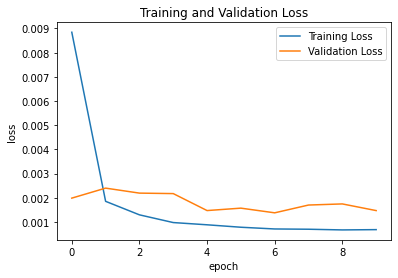

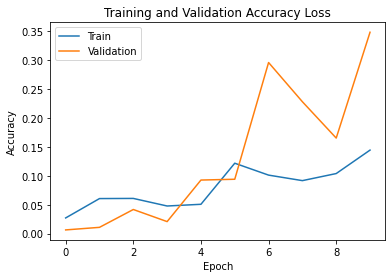

In [ ]:
autoModel.plotgraph(auto_history)

In [ ]:
reconstruction_error = autoModel.predict_reconstruction_error(X_test)


2671/2671 [==============================] - 8s 3ms/step
           reconstruction_error                                            \
                          count       mean        std       min       25%   
true_class                                                                  
0                       85307.0   0.960858   2.937688  0.162715  0.426075   
1                         136.0  30.760948  35.855227  0.358998  6.290533   

                                              
                  50%        75%         max  
true_class                                    
0            0.618259   0.913019  241.268191  
1           13.172308  62.951633  203.117584  


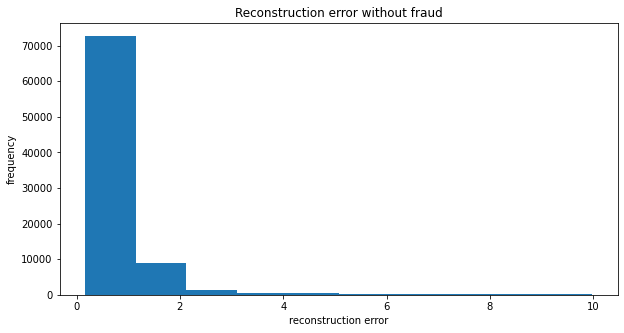

In [ ]:
autoModel.plot_without_fraud()

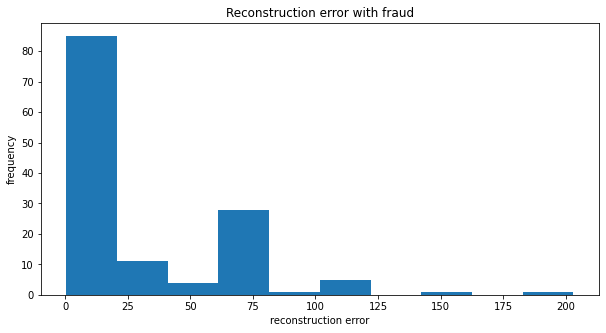

In [ ]:
autoModel.plot_with_fraud()

In [ ]:
autoModel.save_model()

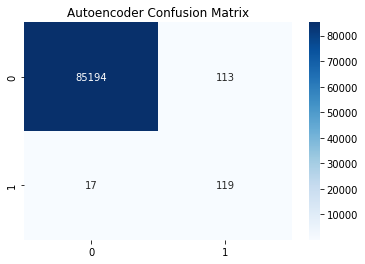

In [ ]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (autoModel.re_errpred [:,1] > 0.5).astype("int32")
confusion_matrix = confusion_matrix(y_test, cm)
sns.heatmap(confusion_matrix, annot=True,fmt = 'd', cmap = "Blues")
plt.title("Autoencoder Confusion Matrix")
plt.show()

In [ ]:
#precision, recall, fscore
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_test, cm)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))

precision: [0.9998005  0.51293103]
recall: [0.99867537 0.875     ]
fscore: [0.99923762 0.64673913]


In [ ]:
#accuracy score
accuracy_score(y_test,cm)

0.9984785178423042

# Credit card fraud detection (Using LSTM) 




### Data Handler class


In [ ]:
class DataHandler:
  def __init__(self, data,):
    self.data = data

  def split(self, test_size=0.15):
    x = self.data.iloc[:, : -1]
    y = self.data.iloc[:, -1]
    (x_train,x_test,y_train,y_test) = train_test_split(x, y, test_size=test_size, stratify=y)
    
    self.x_train = x_train
    self.x_test = x_test
    self.y_train = y_train
    self.y_test = y_test
    return self

  def apply_smote(self):
    
    undersample = NeighbourhoodCleaningRule()
    x, y = undersample.fit_resample(self.x_train, self.y_train)
    self.x_train = x
    self.y_train = y
    # undersample = InstanceHardnessThreshold(random_state=0,
    #                             estimator=LogisticRegression(
    #                                 solver='lbfgs', multi_class='auto'))
    # x, y = undersample.fit_resample(self.x_train, self.y_train)
    # self.x_train = x
    # self.y_train = y
    # oversample = SMOTE()
    # x, y = oversample.fit_resample(self.x_train, self.y_train)
    # self.x_train = x
    # self.y_train = y
   
    return self

  def apply_scaler(self):
    x = self.data.iloc[:, : -1]
    y = self.data.iloc[:, -1]
    scaled_features = StandardScaler().fit_transform(x)
    x = pd.DataFrame(scaled_features, index=x.index, columns=x.columns)

    self.data = pd.concat([x,y], axis=1)
    return self

  def reshape_3d(self):
    self.x_train = self.x_train.values.reshape((self.x_train.shape[0], 1, self.x_train.shape[1]))
    self.x_test = self.x_test.values.reshape((self.x_test.shape[0], 1, self.x_test.shape[1]))
    return self

  def drop_columns(self, columns):
    self.data = self.data.drop(columns,axis =1)
    return self
    
  def get_data(self):
    skf = StratifiedKFold(n_splits=20)
    self.skf = skf.split(self.x_train, self.y_train)
    return (self.x_train, self.y_train, self.x_test, self.y_test, self.skf)

### LSTM model class

In [ ]:
class LSTMModel:
  def __init__(self, input_shape, output_size = 1, lstm_nodes = 50, dropout= 0.4, rec_dropout = 0.35):
    self.input_shape = input_shape
    self.output_size = output_size
    self.lstm_nodes = lstm_nodes
    self.dropout = dropout
    self.rec_dropout = rec_dropout
    self.is_built = False
    self.history = []


  def build(self):
    input_layer = Input(self.input_shape)
    h_layer_1 = LSTM(self.lstm_nodes,return_sequences=True, dropout=self.dropout, recurrent_dropout=self.rec_dropout)(input_layer)
    h_layer_2 = LSTM(self.lstm_nodes,return_sequences=True, dropout=self.dropout, recurrent_dropout=self.rec_dropout)(h_layer_1)
    # h_layer_3 = LSTM(self.lstm_nodes,return_sequences=True, dropout=self.dropout, recurrent_dropout=self.rec_dropout)(h_layer_2)
    
    output_layer = Dense(self.output_size, activation='sigmoid')(h_layer_2)
    self.model = Model(input_layer, output_layer)
    self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', metrics.Precision(name="percision"), metrics.Recall(name="recall")])
    self.is_built = True

  def plot_model_arch(self):
    if not self.is_built:
      print("Please build the model first.")
      return
      
    plot_model(self.model, to_file = 'lstm_arch.jpg', show_shapes = True, show_layer_names = True, dpi=1200)
    img = np.asarray(Image.open('lstm_arch.jpg'))
    imgplot = pyplot.imshow(img)

  def fit_model(self, lstm_x_train, lstm_y_train, lstm_x_val, lstm_y_val ,skf, batch_size = 2000, epochs = 100):
    if not self.is_built:
      print("Please build the model first.")
      return

    # for i, (train_index, test_index) in enumerate(skf):  
    #   print(lstm_x_train.shape)
    #   print(lstm_y_train.shape)

    #   train_skf_x = lstm_x_train[train_index]
    #   train_skf_y = lstm_y_train[train_index]
    #   test_skf_x = lstm_x_train[test_index]
    #   test_skf_y = lstm_y_train[test_index]
    #   print("On fold: ", i)
    #   history = self.model.fit(train_skf_x, train_skf_y,epochs=epochs,batch_size=batch_size, validation_data=(test_skf_x, test_skf_y))
    #   self.history.append(history) 
    history = self.model.fit(lstm_x_train, lstm_y_train,epochs=epochs,batch_size=batch_size, validation_data=(lstm_x_val, lstm_y_val))
    self.history.append(history) 


  def plot_history(self):
    fold_no = 1
    for history in self.history:
      print("On fold: " , fold_no)
      pyplot.figure(dpi=700)
      pyplot.subplot(221)
      pyplot.title('Loss')
      pyplot.plot(history.history['loss'], label='train')
      pyplot.plot(history.history['val_loss'], label='test')
      pyplot.legend()
      pyplot.subplot(222)
      pyplot.title('Accuracy')
      pyplot.plot(history.history['accuracy'], label='train')
      pyplot.plot(history.history['val_accuracy'], label='test')
      pyplot.legend()

      pyplot.subplot(223)
      pyplot.title('Recall')
      pyplot.plot(history.history['recall'], label='train')
      pyplot.plot(history.history['val_recall'], label='test')
      pyplot.legend()

      pyplot.subplot(224)
      pyplot.title('Persicion')
      pyplot.plot(history.history['percision'], label='train')
      pyplot.plot(history.history['val_percision'], label='test')
      pyplot.legend()

      pyplot.tight_layout()

      pyplot.show()
      fold_no = fold_no + 1

  def predict(self, x_test):
    y_probs = self.model.predict(x_test, verbose=0)
    y_probs = y_probs[:, 0]
    y_probs = (y_probs > 0.5).astype(np.float32)
    return y_probs

  def evaluate_model(self, x_test, y_test):
    y_probs = self.predict(x_test)
    accuracy = accuracy_score(y_test, y_probs)
    print('Accuracy: %f' % accuracy)
    precision = precision_score(y_test, y_probs)
    print('Precision: %f' % precision)
    recall = recall_score(y_test, y_probs)
    print('Recall: %f' % recall)
    
    f1 = (2 * recall * precision) / (recall + precision)
    print('F1: %f' % f1)
     
  def save_model(self, path = 'lstm_saved_model.h5'):
    self.model.save(path)
    print(f"Saved model at '{path}'.")

### Loading the Data


In [ ]:
drive.mount('/content/gdrive')
lstm_dataset = pd.read_csv('/content/gdrive/MyDrive/Datasets/creditcard.csv', na_filter=True)
cols_to_del = ['Time (second)', 'V5', 'V6', 'V7', 'V8', 'V9','V13','V15', 'V16',  'V18', 'V19', 'V20','V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']
(lstm_x_train, lstm_y_train, lstm_x_test, lstm_y_test, lstm_skf) = DataHandler(lstm_dataset).drop_columns(cols_to_del).apply_scaler().split().apply_smote().reshape_3d().get_data()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Fitting model


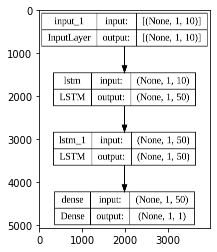

In [ ]:
lstm_model = LSTMModel(input_shape=(1,10), lstm_nodes = 50)
lstm_model.build()
lstm_model.plot_model_arch()

In [ ]:
lstm_model.fit_model(lstm_x_train,lstm_y_train, lstm_x_val  = lstm_x_test, lstm_y_val= lstm_y_test, skf= lstm_skf, batch_size = 2000, epochs=40)

Epoch 1/40
121/121 [==============================] - 19s 84ms/step - loss: 0.4037 - accuracy: 0.9760 - percision: 0.0170 - recall: 0.2273 - val_loss: 0.0393 - val_accuracy: 0.9983 - val_percision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/40
121/121 [==============================] - 6s 48ms/step - loss: 0.0232 - accuracy: 0.9984 - percision: 0.5684 - recall: 0.2584 - val_loss: 0.0058 - val_accuracy: 0.9990 - val_percision: 0.8163 - val_recall: 0.5405
Epoch 3/40
121/121 [==============================] - 8s 64ms/step - loss: 0.0086 - accuracy: 0.9989 - percision: 0.7794 - recall: 0.5072 - val_loss: 0.0035 - val_accuracy: 0.9994 - val_percision: 0.8310 - val_recall: 0.7973
Epoch 4/40
121/121 [==============================] - 6s 47ms/step - loss: 0.0061 - accuracy: 0.9991 - percision: 0.8307 - recall: 0.6220 - val_loss: 0.0030 - val_accuracy: 0.9994 - val_percision: 0.8158 - val_recall: 0.8378
Epoch 5/40
121/121 [==============================] - 8s 65ms/step - loss: 0.0054 - accurac

### Plotting training graph

On fold:  1


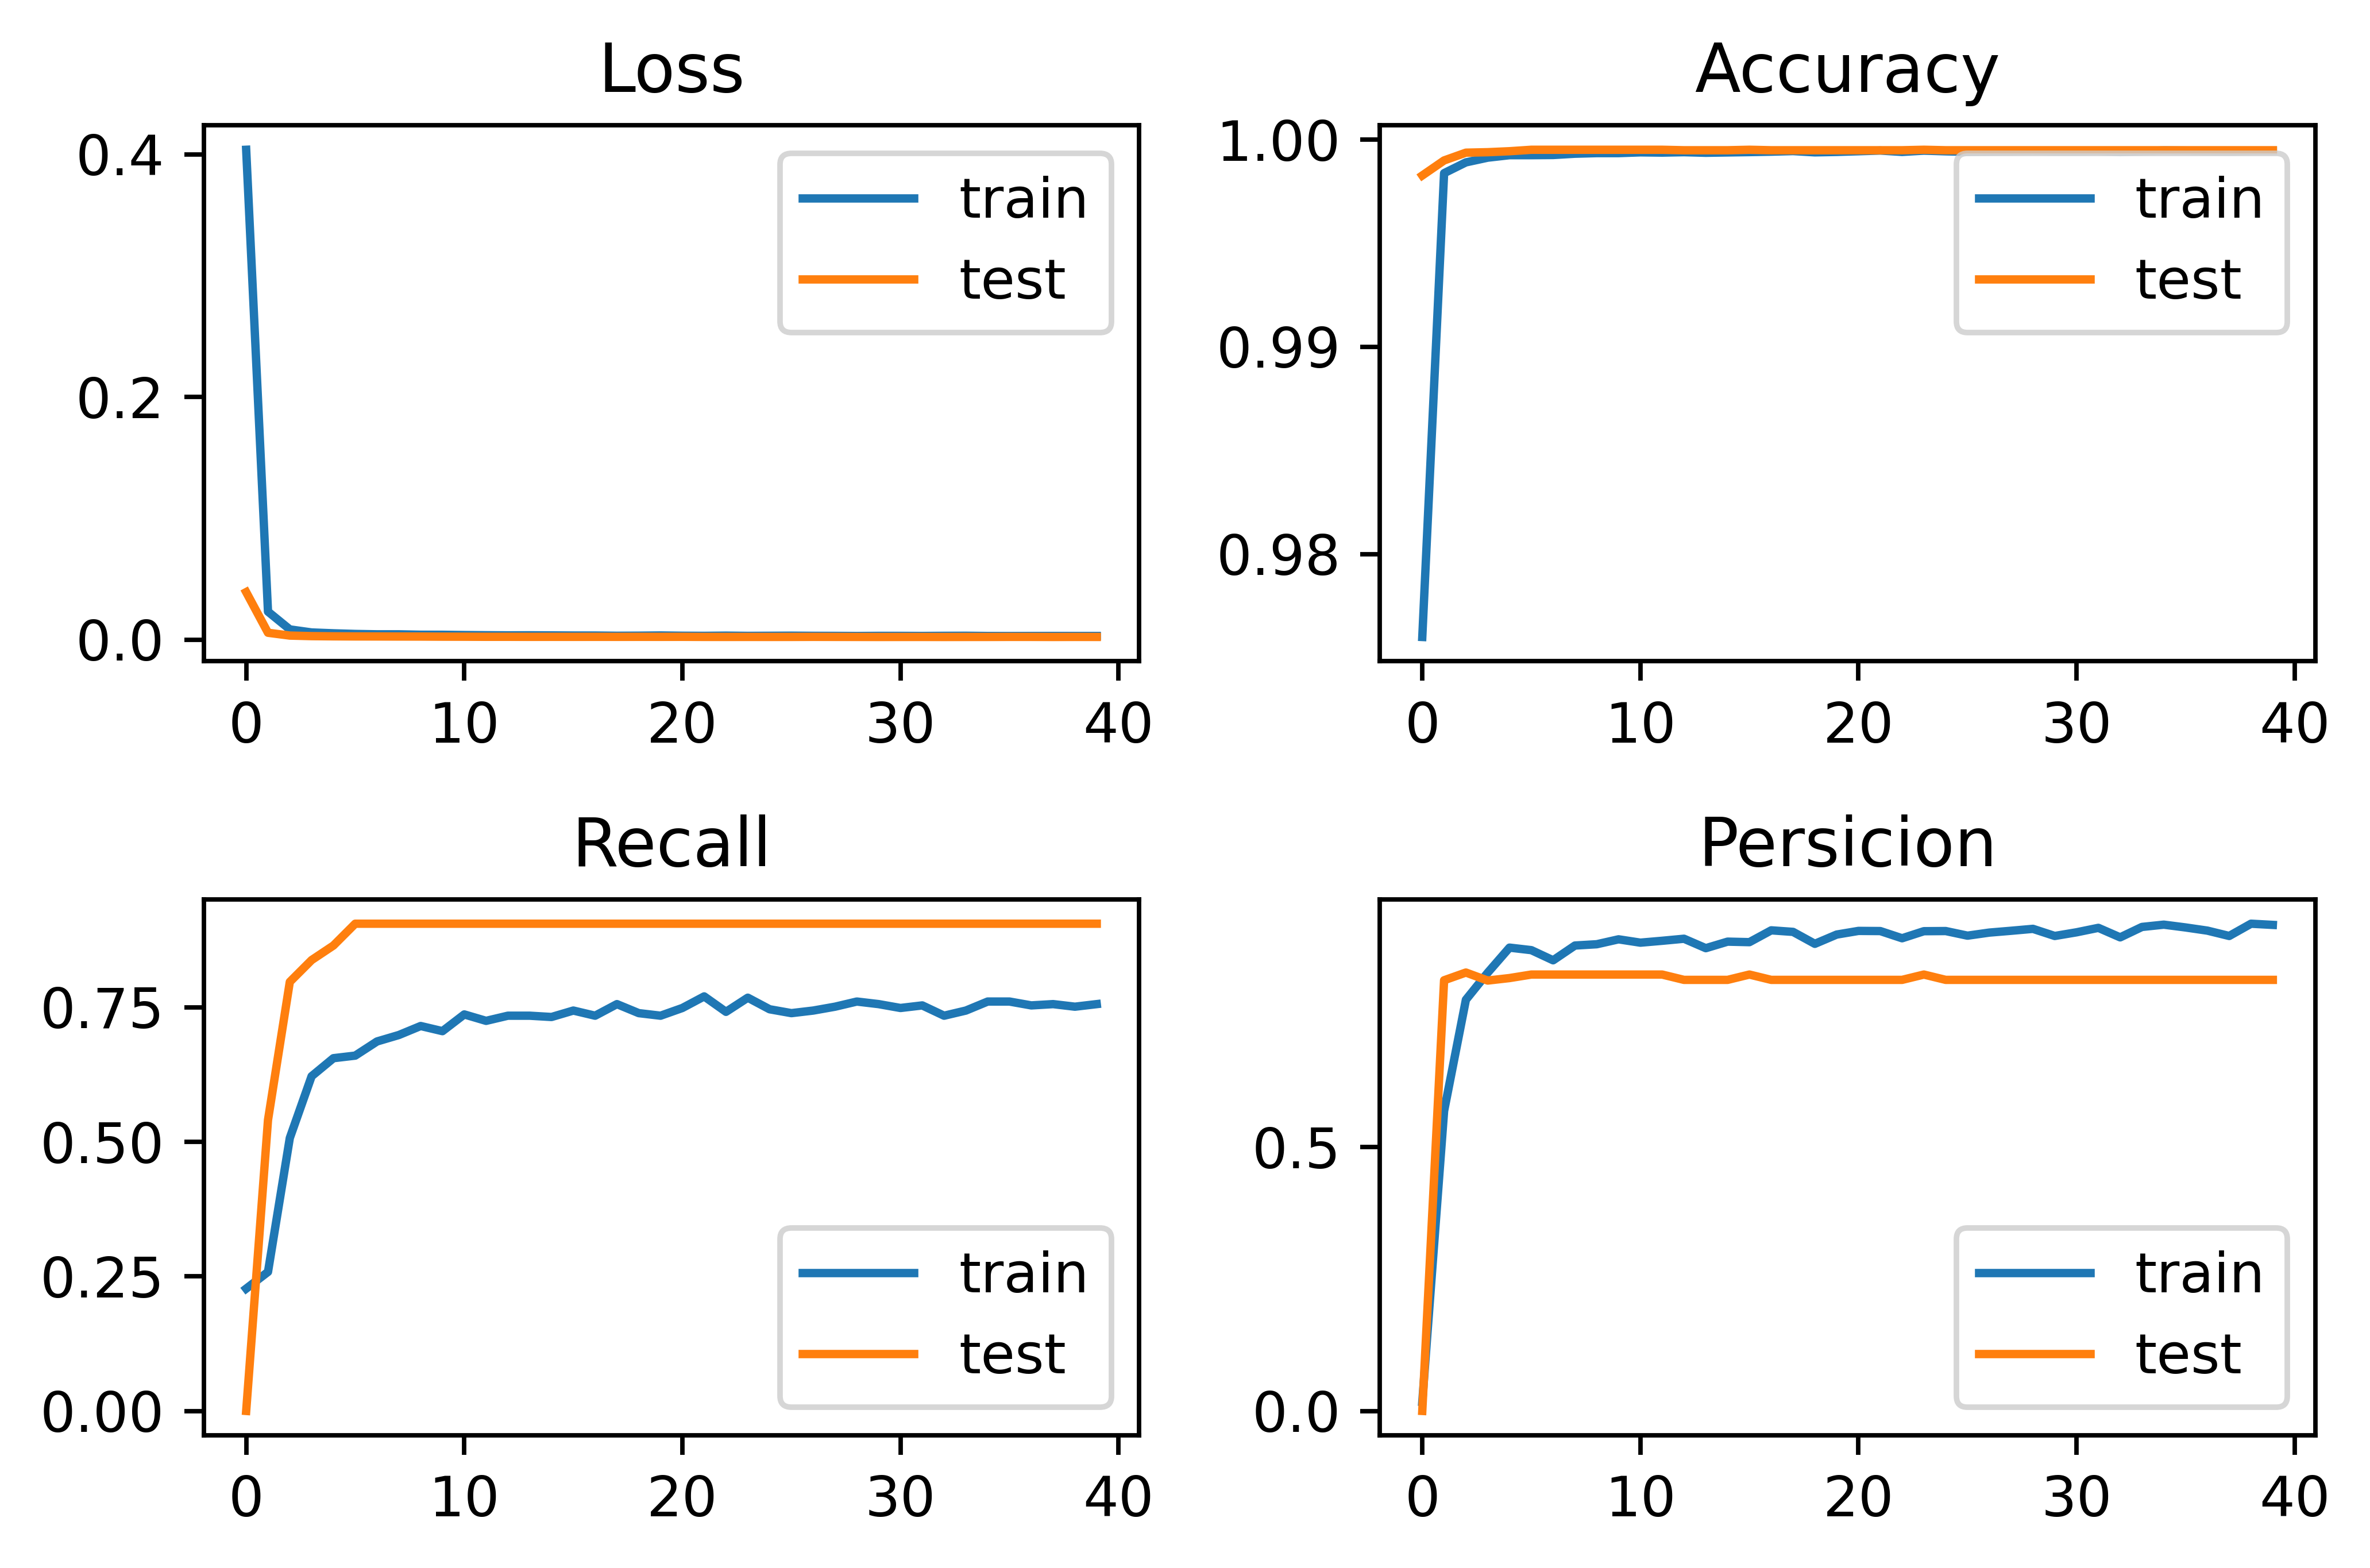

In [ ]:
lstm_model.plot_history()

### Saving the model

In [ ]:
lstm_model.save_model()

Saved model at 'lstm_saved_model.h5'.


### Evaluating the model

In [ ]:
lstm_model.evaluate_model(lstm_x_test, lstm_y_test)

Accuracy: 0.999485
Precision: 0.817073
Recall: 0.905405
F1: 0.858974


# GAN

In [ ]:
#data = pd.read_csv("/content/gdrive/MyDrive/MSc Data Science/datasets/creditcard.csv", encoding = "latin-1") # Abin
data = pd.read_csv("/content//gdrive/MyDrive/creditcard.csv") #Muskan

In [ ]:
class1_data=data[data.Class==1]
class1_data=class1_data.drop(['Time (second)','Amount','Class'],axis=1)
class1_data.values

array([[-2.31222654e+00,  1.95199201e+00, -1.60985073e+00, ...,
         1.77839798e-01,  2.61145003e-01, -1.43275875e-01],
       [-3.04354062e+00, -3.15730712e+00,  1.08846278e+00, ...,
        -1.45361715e-01, -2.52773123e-01,  3.57642250e-02],
       [-2.30334957e+00,  1.75924746e+00, -3.59744743e-01, ...,
        -5.42627889e-01,  3.95659890e-02, -1.53028797e-01],
       ...,
       [-6.76142671e-01,  1.12636606e+00, -2.21369952e+00, ...,
         4.71110963e-01,  3.85107449e-01,  1.94361479e-01],
       [-3.11383161e+00,  5.85864172e-01, -5.39973021e+00, ...,
         6.06115810e-01,  8.84875540e-01, -2.53700319e-01],
       [ 1.99197610e+00,  1.58475887e-01, -2.58344065e+00, ...,
        -2.89616586e-01,  2.98758200e-03, -1.53088130e-02]])

In [ ]:
real_data = class1_data.values

In [ ]:
class GAN:
  """
    A class that implements Generative Adversarial Networks (GANs).
    
    Attributes:
    -----------
    None
    
    Methods:
    --------
    __init__(self) -> None:
        Initializes the GAN class with no attributes.
        
    generator(self, G_in, dense_dim = 200, out_dim = 28, lr = 1e-4):
        Returns a generative model G given an input tensor G_in, dense dimension, output dimension, and learning rate.
        
    discriminator(self, D_in, lr = 2e-4, drate=.25, n_channels=28, conv_sz=5, leak=.2):
        Returns a discriminative model D given an input tensor D_in, learning rate, dropout rate, number of channels, convolution size, and leak.
        
    set_trainability(self, model, trainable=False):
        Sets the trainability of all layers of a given model to either True or False.
        
    build_GAN(self, GAN_in, G, D):
        Creates a GAN model given an input tensor, generative model G, and discriminative model D.
        
    sample_data_and_gen(self, G, noise_dim=10):
        Generates a sample of real and generated data for the GAN training process.
        
    pretrain(self, G, D, noise_dim=10, batch_size=32):
        Pretrains the discriminative model D with a single batch of generated and real data.
        
    generate_random_sample_noise(self, G, noise_dim = 10):
        Generates noise for the generative model G.
        
    train(self, GAN, G, D, epochs = 1000, noise_dim=10, batch_size = 32, verbose = False, v_freq = 50):
        Trains the GAN model given a GAN model, generative model G, discriminative model D, number of epochs, noise dimension, batch size, and verbosity parameters.
    """

  def __init__(self) -> None:
    return None

  def generator(self, G_in, dense_dim = 200, out_dim = 28, lr = 1e-4): 
    """
    Get the generative model for the GAN.

    This method constructs the generative model using the given input tensor and hyperparameters.
    The generative model is composed of a fully connected layer, an activation layer,
    and another fully connected layer.
    It is compiled using the binary crossentropy loss function and stochastic gradient descent optimizer with a given learning rate.

    Args:
    G_in (tensorflow.keras.layers.Input): Input tensor for the generative model.
    dense_dim (int): Number of units in the fully connected layer. Defaults to 200.
    out_dim (int): Number of output units. Defaults to 28.
    lr (float): Learning rate for the optimizer. Defaults to 1e-4.

    Returns:
    tuple: A tuple of the generative model and the output tensor of the model.
    """  
    x = Dense(dense_dim)(G_in)
    x = Activation('relu')(x)
    G_out = Dense(out_dim, activation = 'relu')(x)
    G = Model(G_in, G_out)
    opt = SGD(lr = lr)
    G.compile(loss='binary_crossentropy', optimizer='adam')
    return G, G_out
  
  def discriminator(self, D_in, lr = 2e-4, drate = 0.25, n_channels = 28, conv_sz = 5, leak = 0.2):
    """
    Builds and compiles a discriminative model using Convolutional Neural Network.

    Parameters:
        D_in (tensorflow.python.framework.ops.Tensor): Input tensor for the discriminator.
        lr (float): Learning rate for Adam optimizer. Default is 0.001.
        drate (float): Dropout rate. Default is 0.25.
        n_channels (int): Number of filters in the convolutional layer. Default is 28.
        conv_sz (int): Size of the convolutional filter. Default is 5.
        leak (float): Slope of the negative part of the leaky ReLU activation function. Default is 0.2.

    Returns:
        tuple: A tuple containing the discriminator model and the output tensor.
        
    The returned model is a `tf.keras.Model` object, which accepts `D_in` as input and produces
    `D_out` as output. The model is built using the following layers:
    
    - Reshape layer: reshape the input tensor to (-1, 1)
    - Conv1D layer: apply convolutional filter to the input tensor with `n_channels` filters, 
                    `conv_sz` filter size, and ReLU activation function
    - Dropout layer: randomly drop `drate` fraction of the input units
    - Flatten layer: flatten the output tensor
    - Dense layer: fully connected layer with `n_channels` units
    - Dense layer: fully connected layer with 2 units and sigmoid activation function
    
    The model is compiled using binary crossentropy loss and Adam optimizer with learning rate `lr`.
    """
    x = Reshape((-1, 1))(D_in)
    x = Conv1D(n_channels, conv_sz, activation = 'relu')(x)
    x = Dropout(drate)(x)
    x = Flatten()(x)
    x = Dense(n_channels)(x)
    D_out = Dense(2, activation = 'sigmoid')(x)
    D = Model(D_in, D_out)
    dopt = Adam(lr = lr)
    D.compile(loss='binary_crossentropy', optimizer = dopt)
    return D, D_out

  def set_trainability(self, model, trainable=False):
    """
    The set_trainability method sets the trainable flag of a Keras model and all its layers.

    Args:
    model (Keras model): The Keras model to set the trainable flag for.
    trainable (bool): Whether to set the trainable flag to True or False.
    """
    model.trainable = trainable
    for layer in model.layers:
        layer.trainable = trainable
        
  def build_GAN(self, GAN_in, G, D):
    """
    Combines the generator and discriminator models to create a GAN model.

    Parameters:
    -----------
    GAN_in : Tensor
        Input tensor for GAN model.
    G : Model
        Generator model.
    D : Model
        Discriminator model.

    Returns:
    --------
    GAN : Model
        Combined GAN model.
    GAN_out : Tensor
        Output tensor of the GAN model.
    """
    self.set_trainability(D, False)
    x = G(GAN_in)
    GAN_out = D(x)
    GAN = Model(GAN_in, GAN_out)
    GAN.compile(loss='binary_crossentropy', optimizer=G.optimizer)
    return GAN, GAN_out

  def sample_data_and_gen(self, G, noise_dim=10 ):
    """
    Generates a sample dataset by combining real data and synthetic data created by the generator.

    Args:
        G (tensorflow.keras.models.Model): The generator model used to create synthetic data.
        noise_dim (int): The dimensionality of the noise vector used to generate synthetic data.

    Returns:
        Tuple: A tuple containing X (the combined dataset) and y (the labels for the combined dataset).
    """
    XT = real_data 
    XN_noise = np.random.uniform(0,1,size=[492,noise_dim ])
    XN = G.predict(XN_noise)
    X = np.concatenate((XT,XN))
    y = np.zeros((2 * 492, 2))
    y[:492, 1] = 1
    y[492:, 0] = 1
    return X, y

  def pretrain(self, G, D, noise_dim=10,batch_size=32):

    """
    Pretrain the discriminator `D` using generated and real data.

    Args:
        G (Model): The generator model.
        D (Model): The discriminator model.
        noise_dim (int): The size of the noise vector used by the generator. Defaults to 10.
        batch_size (int): The batch size used during training. Defaults to 32.

    Returns:
        None
    """
    X, y = self.sample_data_and_gen(G, noise_dim = noise_dim)
    self.set_trainability(D, True)
    D.fit(X, y, epochs=1, batch_size=batch_size)

  def generate_random_sample_noise(self, G, noise_dim = 10, ):
    """
    The generate_random_sample_noise function generates random noise for the generator network of the GAN model.

    Parameters:

    G: The generator network model.
    noise_dim (optional): The dimensionality of the noise vector. Default is 10.
    Returns:

    X: A numpy array of shape (492, noise_dim) representing the random noise vectors.
    y: A numpy array of shape (492, 2) representing the target labels for the noise vectors.
    The second column of this array is set to 1 to indicate that these samples are generated (as opposed to real data).
    """
    X = np.random.uniform(0, 1, size = [492, noise_dim])
    y = np.zeros((492, 2))
    y[:, 1] = 1
    return X, y

  def train_GAN(self, GAN, G, D, epochs = 1000, noise_dim = 10, batch_size = 32, verbose = False, v_freq = 50):
    """
    Train the GAN model for a specified number of epochs.

    Args:
        GAN (keras.Model): A compiled Keras model that represents the GAN architecture.
        G (keras.Model): A compiled Keras model that represents the generator architecture.
        D (keras.Model): A compiled Keras model that represents the discriminator architecture.
        epochs (int): The number of epochs to train the model for. The default value is 500.
        noise_dim (int): The dimension of the noise vector used as input for the generator. The default value is 10.
        batch_size (int): The batch size used for training. The default value is 32.
        verbose (bool): Whether to print progress updates during training. The default value is False.
        v_freq (int): The frequency (in epochs) of progress updates. Only used if verbose is True. The default value is 50.

    Returns:
        Tuple: A tuple containing two lists of floats: d_loss and g_loss. The first list contains the discriminative loss
        for each epoch, and the second list contains the generative loss for each epoch.

    The `train` method takes in the compiled GAN model (`GAN`), the compiled generator model (`G`), and the compiled
    discriminator model (`D`) as arguments, along with other optional hyperparameters.

    During training, the `train` method generates a batch of real and fake data using the generator model (`G`). It then
    trains the discriminator model (`D`) on the real and fake data batches separately and records the discriminative
    loss.

    Next, the method generates a new batch of fake data using the generator model (`G`) and trains the GAN model (`GAN`)
    with the generated fake data and a set of labels indicating that the data is real. The objective is to train the
    generator to generate realistic data that can fool the discriminator.

    The method continues to loop through the specified number of epochs, alternating between training the generator and
    discriminator models, and recording the generative and discriminative loss for each epoch.

    The method returns a tuple of two lists: `d_loss` and `g_loss`. The `d_loss` list contains the discriminative loss
    for each epoch, and the `g_loss` list contains the generative loss for each epoch.
    """
    d_loss = []
    g_loss = []
    e_range = range(epochs)
    if verbose:
        e_range = tqdm(e_range)
    for epoch in e_range:
        X, y = self.sample_data_and_gen(G, noise_dim = noise_dim)
        self.set_trainability(D, True)
        d_loss.append(D.train_on_batch(X, y))
        
        X, y = self.generate_random_sample_noise(G, noise_dim = noise_dim)
        self.set_trainability(D, False)
        g_loss.append(GAN.train_on_batch(X, y))
        if verbose and (epoch + 1) % v_freq == 0:
            print("Epoch #{}: Generative Loss: {}, Discriminative Loss: {}".format(epoch + 1, g_loss[-1], d_loss[-1]))
    return d_loss, g_loss


In [ ]:
# making an object of GAN
gan = GAN()

In [ ]:
G_in = Input(shape=[10]) # <tf.Tensor 'input_1:0' shape=(?, 10) dtype=float32>
G, G_out = gan.generator(G_in) #G_out= <tf.Tensor 'dense_2/Tanh:0' shape=(?, 50) dtype=float32>
G.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_28 (Dense)            (None, 200)               2200      
                                                                 
 activation_3 (Activation)   (None, 200)               0         
                                                                 
 dense_29 (Dense)            (None, 28)                5628      
                                                                 
Total params: 7,828
Trainable params: 7,828
Non-trainable params: 0
_________________________________________________________________


In [ ]:
D_in = Input(shape=[28])
D, D_out = gan.discriminator(D_in)
D.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28)]              0         
                                                                 
 reshape_1 (Reshape)         (None, 28, 1)             0         
                                                                 
 conv1d_3 (Conv1D)           (None, 24, 28)            168       
                                                                 
 dropout_4 (Dropout)         (None, 24, 28)            0         
                                                                 
 flatten_2 (Flatten)         (None, 672)               0         
                                                                 
 dense_30 (Dense)            (None, 28)                18844     
                                                                 
 dense_31 (Dense)            (None, 2)                 58  

In [ ]:
GAN_in = Input([10])
GAN, GAN_out = gan.build_GAN(GAN_in, G, D)
GAN.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 10)]              0         
                                                                 
 model_5 (Functional)        (None, 28)                7828      
                                                                 
 model_6 (Functional)        (None, 2)                 19070     
                                                                 
Total params: 26,898
Trainable params: 7,828
Non-trainable params: 19,070
_________________________________________________________________


In [ ]:
gan.pretrain(G, D)

31/31 [==============================] - 1s 3ms/step - loss: 0.5332


In [ ]:
d_loss, g_loss = gan.train_GAN(GAN, G, D, verbose = True)

  0%|          | 0/1000 [00:00<?, ?it/s]

16/16 [==============================] - 0s 1ms/step
Epoch #50: Generative Loss: 0.980048656463623, Discriminative Loss: 0.3162202537059784
16/16 [==============================] - 0s 2ms/step
Epoch #100: Generative Loss: 0.9486145377159119, Discriminative Loss: 0.3111884593963623
16/16 [==============================] - 0s 2ms/step
Epoch #150: Generative Loss: 1.006034255027771, Discriminative Loss: 0.2876877188682556
16/16 [==============================] - 0s 1ms/step
Epoch #200: Generative Loss: 1.3336727619171143, Discriminative Loss: 0.20840813219547272
16/16 [==============================] - 0s 2ms/step
Epoch #250: Generative Loss: 1.6322085857391357, Discriminative Loss: 0.15340131521224976
16/16 [==============================] - 0s 2ms/step
Epoch #300: Generative Loss: 2.0830745697021484, Discriminative Loss: 0.10224234312772751
16/16 [==============================] - 0s 2ms/step
Epoch #350: Generative Loss: 2.452042818069458, Discriminative Loss: 0.07193058729171753
16/16 

Text(0, 0.5, 'Loss')

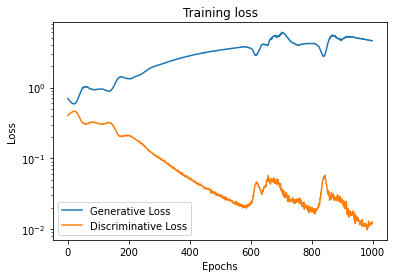

In [ ]:
ax = pd.DataFrame(
    {
        'Generative Loss': g_loss,
        'Discriminative Loss': d_loss,
    }
).plot(title='Training loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

In [ ]:
# doubled the original 492 Fraud cases. Create a total of 981 samples..! (Only look at 492 from the back..)
N_VIEWED_SAMPLES = 2
data_and_gen, _ = gan.sample_data_and_gen(G)

16/16 [==============================] - 0s 1ms/step


In [ ]:
all_class1_df = [pd.DataFrame(data_and_gen)]
for i in range (577):
    new_data,_= gan.sample_data_and_gen(G)
    all_class1_df.append(pd.DataFrame(new_data)[492:])
class1_data_balanced = pd.concat(all_class1_df)    

16/16 [==============================] - 0s 2ms/step


In [ ]:
class1_data_balanced.columns=["V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28"]

In [ ]:
label_class1=[]
for j in range(284868):
    label_class1.append(1)
label_class1 = pd.DataFrame(label_class1)
label_class1.columns=["Class"]
label_class1.tail()

,Class
284863,1
284864,1
284865,1
284866,1
284867,1


In [ ]:
#CLASS 1 

class1_data_balanced=class1_data_balanced.reset_index()
class1_data_balanced = pd.concat([class1_data_balanced,label_class1],axis=1)
class1_data_balanced.tail()

,index,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
284863,979,0.0,0.0,0.0,1.644759,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
284864,980,0.0,0.0,0.0,2.454355,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
284865,981,0.0,0.0,0.0,2.043198,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
284866,982,0.0,0.0,0.0,1.520497,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
284867,983,0.0,0.0,0.0,1.859456,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
class0_data=data[data.Class==0].drop(["Time (second)","Amount"],axis=1)
class0_data.head()
len(class0_data)

284315

In [ ]:
class1_data_balanced=class1_data_balanced.drop(["index"],axis=1)
class1_data_balanced.tail()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
284863,0.0,0.0,0.0,1.644759,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
284864,0.0,0.0,0.0,2.454355,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
284865,0.0,0.0,0.0,2.043198,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
284866,0.0,0.0,0.0,1.520497,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
284867,0.0,0.0,0.0,1.859456,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
frame=[class0_data,class1_data_balanced]
final_df=pd.concat(frame)
final_df=final_df.reset_index()
final_df=final_df.drop(["index"],axis=1)
final_df.tail()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
569178,0.0,0.0,0.0,1.644759,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
569179,0.0,0.0,0.0,2.454355,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
569180,0.0,0.0,0.0,2.043198,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
569181,0.0,0.0,0.0,1.520497,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
569182,0.0,0.0,0.0,1.859456,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


### DNN MODEL


Data Segmentation

In [ ]:
class GANDeepLearningModel():
  """
  The GANDeepLearningModel class is used to create a Generative Adversarial Network (GAN) model in Python.
  The train_deep_learning_model method trains this model on a given dataset final_df,
  and returns the training history of the model.
  """
  def __init__(self):
    return None

  def train_deep_learning_model(self):
    """
    The train_deep_learning_model function trains a deep learning model using the GAN architecture on a given dataset.
    The function first prepares the dataset by dropping the "Class" column and splitting it into training and 
    testing sets using a test size of 0.1 and a random state of 42.

    The training set is further split into a partial training set and a validation set with the first 100,000 samples used for validation.
    The function then converts all input data to numpy arrays of type float32.

    The model architecture consists of a sequential stack of dense layers with ReLU activation and a dropout rate of 0.5.
    The final layer is a dense layer with a softmax activation function and two output nodes, representing the binary classification problem.

    The model is compiled using the RMSprop optimizer with a learning rate of 0.001 and a binary cross-entropy loss function with accuracy as the evaluation metric.

    The function then performs one-hot encoding on the target variables of the training and validation sets.
    Finally, the model is trained on the partial training set with 50 epochs, a batch size of 500, 
    and the validation set is used for monitoring the model performance during training.

    The function returns the training history object that contains the loss and accuracy values for both the training and validation sets at each epoch.
    """

    # splitting the dataset
    X = final_df.drop(['Class'], axis = 1)
    y = final_df['Class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)
    
    # partial training
    x_val = X_train[:100000]
    partial_x_train = X_train[100000:]
    y_val = y_train[:100000]
    partial_y_train = y_train[100000:]
    x_val = np.asarray(x_val).astype('float32')
    partial_x_train = np.asarray(partial_x_train).astype('float32')
    y_val = np.asarray(y_val).astype('float32')
    partial_y_train = np.asarray(partial_y_train).astype('float32')

    # adding the keras sequential model
    model = models.Sequential()

    # 1st layer
    model.add(layers.Dense(28, activation='relu', input_dim=28))
    model.add(Dropout(0.5))
    # 2nd layer
    model.add(layers.Dense(27, activation='relu'))
    model.add(Dropout(0.5))
    # 3rd layer
    model.add(layers.Dense(26, activation='relu'))
    model.add(Dropout(0.5))
    # 4th layer
    model.add(layers.Dense(25, activation='relu'))
    model.add(Dropout(0.5))
    # 5th layer
    model.add(layers.Dense(24, activation='relu'))
    model.add(Dropout(0.5)) 
    # 6th layer
    model.add(layers.Dense(12, activation='relu'))
    model.add(Dropout(0.5))  
    # 7th layer
    model.add(layers.Dense(6, activation='relu'))
    model.add(Dropout(0.5))  
    # 8th layer
    model.add(layers.Dense(3, activation='relu'))
    model.add(Dropout(0.5))  

    # the final layer
    model.add(layers.Dense(2, activation='softmax'))
  
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[Recall()])
  
  
    x_val = X_train[:100000]
    partial_x_train = X_train[100000:]
    y_val = y_train[:100000]
    partial_y_train = y_train[100000:]
    x_val = np.asarray(x_val).astype('float32')
    partial_x_train = np.asarray(partial_x_train).astype('float32')
    y_val = np.asarray(y_val).astype('float32')
    partial_y_train = np.asarray(partial_y_train).astype('float32')
    y_val = to_categorical(y_val)
    partial_y_train = to_categorical(partial_y_train)

    history = model.fit(partial_x_train,
                        partial_y_train,
                        epochs = 50,
                        batch_size = 500,
                        validation_data = (x_val, y_val))
    
    model.save("gandnn.h5")

    return history

  def evaluate_GAN_Recall(self):
    # splitting the dataset
    X = final_df.drop(['Class'], axis = 1)
    y = final_df['Class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)
    
    # partial training
    x_val = X_train[:100000]
    partial_x_train = X_train[100000:]
    y_val = y_train[:100000]
    partial_y_train = y_train[100000:]
    x_val = np.asarray(x_val).astype('float32')
    partial_x_train = np.asarray(partial_x_train).astype('float32')
    y_val = np.asarray(y_val).astype('float32')
    partial_y_train = np.asarray(partial_y_train).astype('float32')

    # adding the keras sequential model
    model = models.Sequential()

    # 1st layer
    model.add(layers.Dense(28, activation='relu', input_dim=28))
    model.add(Dropout(0.5))
    # 2nd layer
    model.add(layers.Dense(27, activation='relu'))
    model.add(Dropout(0.5))
    # 3rd layer
    model.add(layers.Dense(26, activation='relu'))
    model.add(Dropout(0.5))
    # 4th layer
    model.add(layers.Dense(25, activation='relu'))
    model.add(Dropout(0.5))
    # 5th layer
    model.add(layers.Dense(24, activation='relu'))
    model.add(Dropout(0.5)) 
    # 6th layer
    model.add(layers.Dense(12, activation='relu'))
    model.add(Dropout(0.5))  
    # 7th layer
    model.add(layers.Dense(6, activation='relu'))
    model.add(Dropout(0.5))  
    # 8th layer
    model.add(layers.Dense(3, activation='relu'))
    model.add(Dropout(0.5))  

    # the final layer
    model.add(layers.Dense(2, activation='softmax'))
  
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
  
  
    x_val = X_train[:100000]
    partial_x_train = X_train[100000:]
    y_val = y_train[:100000]
    partial_y_train = y_train[100000:]
    x_val = np.asarray(x_val).astype('float32')
    partial_x_train = np.asarray(partial_x_train).astype('float32')
    y_val = np.asarray(y_val).astype('float32')
    partial_y_train = np.asarray(partial_y_train).astype('float32')
    y_val = to_categorical(y_val)
    partial_y_train = to_categorical(partial_y_train)

    X_test = np.asarray(X_test).astype('float32')
    y_test = np.asarray(y_test).astype('float32')
    y_test = to_categorical(y_test)
    results = model.evaluate(X_test, y_test)
    return results[1]

  def save_model(self, path = 'gan_saved_model.h5'):
    self.model.save(path)
    print(f"Saved model at '{path}'.")

In [ ]:
dnn = GANDeepLearningModel()
trained_model = dnn.train_deep_learning_model()

Epoch 1/50
825/825 [==============================] - 8s 7ms/step - loss: 0.6723 - recall_3: 0.5493 - val_loss: 0.3049 - val_recall_3: 0.9991
Epoch 2/50
825/825 [==============================] - 6s 7ms/step - loss: 0.4112 - recall_3: 0.8290 - val_loss: 0.1505 - val_recall_3: 0.9990
Epoch 3/50
825/825 [==============================] - 6s 7ms/step - loss: 0.3651 - recall_3: 0.8470 - val_loss: 0.1345 - val_recall_3: 0.9986
Epoch 4/50
825/825 [==============================] - 5s 7ms/step - loss: 0.3493 - recall_3: 0.8567 - val_loss: 0.1279 - val_recall_3: 0.9990
Epoch 5/50
825/825 [==============================] - 5s 6ms/step - loss: 0.3471 - recall_3: 0.8581 - val_loss: 0.1287 - val_recall_3: 0.9989
Epoch 6/50
825/825 [==============================] - 5s 7ms/step - loss: 0.3430 - recall_3: 0.8583 - val_loss: 0.1271 - val_recall_3: 0.9991
Epoch 7/50
825/825 [==============================] - 4s 5ms/step - loss: 0.3417 - recall_3: 0.8597 - val_loss: 0.1261 - val_recall_3: 0.9989
Epoch 

In [ ]:
trained_model.history.keys()

dict_keys(['loss', 'recall_3', 'val_loss', 'val_recall_3'])

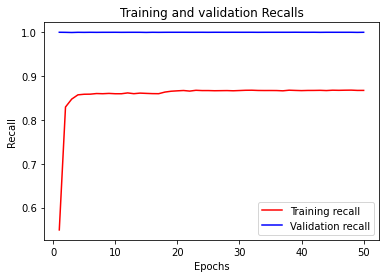

In [ ]:
recall = trained_model.history['recall_3']
val_recall = trained_model.history['val_recall_3']
loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']

epochs = range(1, len(recall) + 1)


plt.plot(epochs, recall, color = 'red', label='Training recall')

plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation Recalls')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.show()

In [ ]:
dnn.evaluate_GAN_Recall()

1779/1779 [==============================] - 4s 2ms/step - loss: 0.6937 - acc: 0.7242


0.7241694331169128

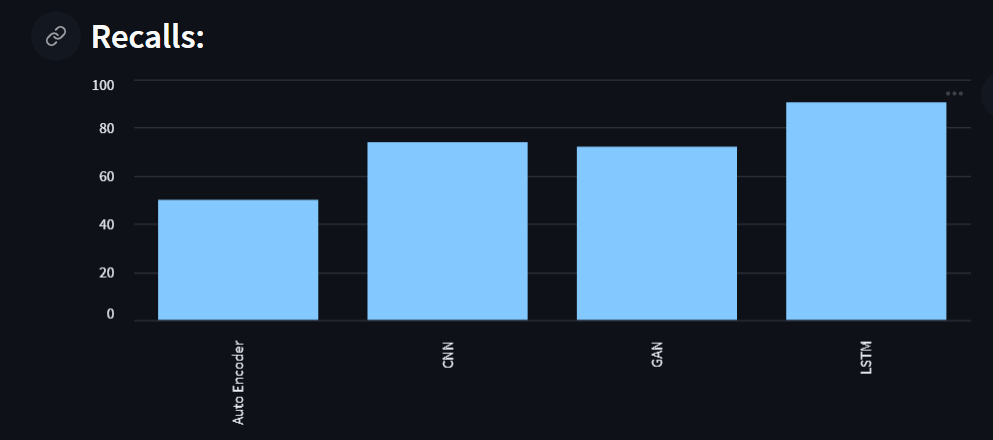


# References:


1. Brownlee, J. (2021) Random oversampling and undersampling for imbalanced classification, MachineLearningMastery.com. Available at: https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/ (Accessed: March 13, 2023). 

2.   Lebichot, Bertrand & Le Borgne, Yann-Aël & He, Liyun & Oblé, Frédéric & Bontempi, Gianluca. (2019). Deep-Learning Domain Adaptation Techniques for Credit Cards Fraud Detection. 10.1007/978-3-030-16841-4_8. 

3. Wen, T. and Keyes, R. (2019) Time series anomaly detection using convolutional neural networks and transfer learning, arXiv.org. Available at: https://arxiv.org/abs/1905.13628 (Accessed: March 14, 2023). 

4. Wang, Z., Yan, W. and Oates, T. (2016) Time Series classification from scratch with Deep Neural Networks: A strong baseline, arXiv.org. Available at: https://arxiv.org/abs/1611.06455 (Accessed: March 15, 2023). 

5. Credit card fraud detection using autoencoders in keras. Available at: https://curiousily.com/posts/credit-card-fraud-detection-using-autoencoders-in-keras/ (Accessed: March 15, 2023). 

**---------------------------------------------------end-of-notebook---------------------------------------------------**